In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from Bio.Seq import Seq
import re
from Bio import pairwise2
import itertools
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42


In [2]:
def get_rev_comp(sequnce_list):
    past_seqs = []
    for seq in sequnce_list:
        seq_obj = Seq(seq)
        search_string = str(seq_obj.reverse_complement())
        if  search_string in past_seqs or seq in past_seqs:
            continue
        else:
            past_seqs.extend([seq,search_string])
    return past_seqs
def get_cyclic_seq(sequence):
    """ input a [sequence] and get all cyclic combiantions of it as a set
    """
    cyc_seqs = []
    seq_len = len(sequence)
    for i in range(seq_len):
        cyc_seqs.append(sequence[i+1:]+sequence[:i+1])
    return set(cyc_seqs)
def get_seq_set(sequence):
    """ emter a [sequence] and get all posiible cyclic and reverse compliments of it as a set
    """
    seq_set = []
    seq_len = len(sequence)
    seq_set.extend( get_rev_comp([ str(sequence) ]) )
    if seq_set[0] == seq_set[1]:
        seq_set.remove(seq_set[1])
        seq_set.extend(get_cyclic_seq(seq_set[0]))
    else:
        seq_set.extend(get_cyclic_seq(seq_set[0]))
        seq_set.extend(get_cyclic_seq(seq_set[1]))
    return set(seq_set)

def rep_list(curr_list):
    return len(curr_list)*[curr_list]

def lambda_count(first,second):
    return lambda x:(x.count(first) + x.count(second)) / len(x)

In [3]:
human_reps = pd.read_csv('fig_S3_data.csv',index_col=0)
human_reps.set_index('repeat_unit', inplace=True)
new_inds = []
for ind in human_reps.index:
    if len(ind)<2:
        new_inds.append(ind*2)
    else:
        new_inds.append(ind)
human_reps.index = new_inds

# Figure 7A

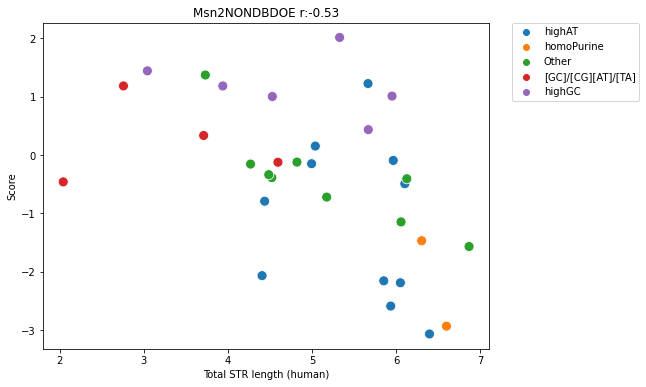

In [4]:
curr_tf = 'Msn2NONDBDOE'
# scat_order = ['highGC','[GC]/[CG][AT]/[TA]','Other']
# tfs = ['Msn2','Msn2DBDOE','Msn2NONDBDOE','Reb1','Mot3','Cbf1','freeMnase']
# data_int = ['delta_median_on','delta_median_off']
# corrs = np.empty((len(tfs),len(data_int)))

# for c,curr_data in enumerate(data_int):
fig,curr_ax = plt.subplots(1,1,figsize=(8,6))
fig.subplots_adjust(hspace=0.5,wspace=0.5)

binding_df = pd.read_csv(curr_tf+'_avg(on,off)_sorted.csv',index_col=0)
list_of_opts = []
for curr_str in binding_df.index:
    list_of_opts.append(list(get_seq_set(curr_str)))

binding_df['opt_len'] = [len(clist) for clist in list_of_opts]
for_df = []
for curr_list in list_of_opts:
    for_df.extend(rep_list(curr_list))
# list(map(rep_list,list_of_lists))
str_dict = dict(zip(np.concatenate(np.array(list_of_opts,dtype=object)),for_df))
fin_df = pd.DataFrame({key:pd.Series(value) for key,value in str_dict.items()}).T

lengths_dict = binding_df['opt_len'].to_dict()
avgs_dict = binding_df['delta_median_on'].to_dict()
fin_df['values'] = np.concatenate(binding_df.reset_index().loc[:,'index'].apply(lambda x: lengths_dict[x]*[(avgs_dict[x])]).values)
fin_df['original'] = fin_df.drop('values',axis=1).reset_index().loc[:,0].values
combined_df = pd.concat([human_reps,fin_df],axis=1)
combined_df['log_sum'] = combined_df.summed_length.apply(np.log10).values
combined_df = combined_df.loc[combined_df.summed_length.dropna().index,:].sort_values(by='values')

mfunc = lambda_count('A','T')
highAT = list((combined_df.reset_index()['index'].apply(mfunc)>0.6).values)
mfunc = lambda_count('G','C')
highGC = list((combined_df.reset_index()['index'].apply(mfunc)>0.6).values)
doubleGCAT = ['GCAT','CGAT','GCTA','CGTA']
in_str = []
for curr_str in combined_df.index:
    curr_str = curr_str*3
    in_str.append(any(substring in curr_str for substring in doubleGCAT))

mfunc = lambda_count('G','A')
homoPurinesA = (combined_df.reset_index()['index'].apply(mfunc)==1).values
mfunc = lambda_count('C','T')
homoPurinesB = (combined_df.reset_index()['index'].apply(mfunc)==1).values
homoPurines = np.logical_or(homoPurinesA,homoPurinesB)
    
STR_info = ['highGC' if b1 else '[GC]/[CG][AT]/[TA]' if b2 else 'highAT' 
            if b3 else 'homoPurine' if b4 else 'Other' for b1, b2, b3 ,b4
            in zip(highGC, in_str,highAT,homoPurines)]
combined_df['STR_info'] = STR_info
combined_df['STR_len'] = combined_df.reset_index()['index'].apply(len).values

# curr_ax = axes.ravel()[i]
# sns.scatterplot(data=combined_df,x='log_sum',y='values',hue='STR_info', s=100, ax=curr_ax, hue_order=scat_order, style='STR_len')
sns.scatterplot(data=combined_df,x='log_sum',y='values',hue='STR_info', s=100, ax=curr_ax)

curr_ax.set_title(curr_tf + ' r:' + str(np.round(combined_df.corr(method='spearman').iloc[1,2],2)))
curr_ax.set_ylabel('Score')
curr_ax.set_xlabel('Total STR length (human)')
curr_ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    # for i in combined_df.index:
            # curr_ax.annotate(i,(combined_df.log_sum[i],combined_df.loc[i,'values']))
# fig.savefig('nonDBDvhuman.pdf')

# Figure 7B

<AxesSubplot:>

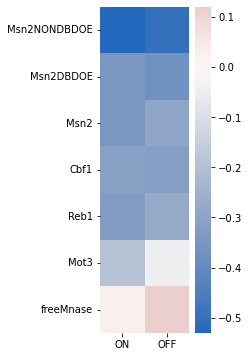

In [5]:
curr_tf = 'Msn2'
scat_order = ['highGC','[GC]/[CG][AT]/[TA]','Other']
tfs = ['Msn2','Msn2DBDOE','Msn2NONDBDOE','Reb1','Mot3','Cbf1','freeMnase']
data_int = ['delta_median_on','delta_median_off']
corrs = np.empty((len(tfs),len(data_int)))

for c,curr_data in enumerate(data_int):
    # fig,axes = plt.subplots(3,3,figsize=(15,15))
    # fig.subplots_adjust(hspace=0.5,wspace=0.5)
    for i,curr_tf in enumerate(tfs):
        binding_df = pd.read_csv(curr_tf+'_avg(on,off)_sorted.csv',index_col=0)
        list_of_opts = []
        for curr_str in binding_df.index:
            list_of_opts.append(list(get_seq_set(curr_str)))

        binding_df['opt_len'] = [len(clist) for clist in list_of_opts]
        for_df = []
        for curr_list in list_of_opts:
            for_df.extend(rep_list(curr_list))
        # list(map(rep_list,list_of_lists))
        str_dict = dict(zip(np.concatenate(np.array(list_of_opts,dtype=object)),for_df))
        fin_df = pd.DataFrame({key:pd.Series(value) for key,value in str_dict.items()}).T

        lengths_dict = binding_df['opt_len'].to_dict()
        avgs_dict = binding_df[curr_data].to_dict()
        fin_df['values'] = np.concatenate(binding_df.reset_index().loc[:,'index'].apply(lambda x: lengths_dict[x]*[(avgs_dict[x])]).values)
        fin_df['original'] = fin_df.drop('values',axis=1).reset_index().loc[:,0].values
        combined_df = pd.concat([human_reps,fin_df],axis=1)
        combined_df['log_sum'] = combined_df.summed_length.apply(np.log10).values
        combined_df = combined_df.loc[combined_df.summed_length.dropna().index,:].sort_values(by='values')
        corrs[i,c] = np.round(combined_df.corr(method='spearman').iloc[1,2],2)

        mfunc = lambda x:(x.count('G') + x.count('C')) / len(x)
        highGC = list((combined_df.reset_index()['index'].apply(mfunc)>0.6).values)
        doubleGCAT = ['GCAT','CGAT','GCTA','CGTA']
        in_str = []
        for curr_str in combined_df.index:
            curr_str = curr_str*3
            in_str.append(any(substring in curr_str for substring in doubleGCAT))
        STR_info = ['highGC' if b1 else '[GC]/[CG][AT]/[TA]' if b2 else 'Other' for b1, b2 in zip(highGC, in_str)]
        combined_df['STR_info']=STR_info
        combined_df['STR_len'] = combined_df.reset_index()['index'].apply(len).values

#         curr_ax = axes.ravel()[i]
#         # sns.scatterplot(data=combined_df,x='log_sum',y='values',hue='STR_info', s=100, ax=curr_ax, hue_order=scat_order, style='STR_len')
#         sns.scatterplot(data=combined_df,x='log_sum',y='values',hue='STR_info', s=100, ax=curr_ax)

#         curr_ax.set_title(curr_tf + ' r:' + str(np.round(combined_df.corr(method='spearman').iloc[1,2],2)))
#         curr_ax.set_ylabel('Score')
#         curr_ax.set_xlabel('Total STR length (human)')
#         curr_ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        # for i in combined_df.index:
            # curr_ax.annotate(i,(combined_df.log_sum[i],combined_df.loc[i,'values']))
corr_df = pd.DataFrame(corrs,index=tfs,columns=['ON','OFF'])
corr_df = corr_df.loc[corr_df.mean(axis=1).sort_values().index,:]
fig,ax = plt.subplots(1,1,figsize=(2,6))
sns.heatmap(corr_df,cmap='vlag',center=0,ax=ax)
# fig.savefig('datavhuman_corrs.pdf')

# other cells

In [6]:
mfunc = lambda_count('A','T')
highAT = list((combined_df.reset_index()['index'].apply(mfunc)>0.6).values)
mfunc = lambda_count('G','C')
highGC = list((combined_df.reset_index()['index'].apply(mfunc)>0.6).values)
doubleGCAT = ['GCAT','CGAT','GCTA','CGTA']
in_str = []
for curr_str in combined_df.index:
    curr_str = curr_str*3
    in_str.append(any(substring in curr_str for substring in doubleGCAT))

mfunc = lambda_count('G','A')
homoPurinesA = (combined_df.reset_index()['index'].apply(mfunc)==1).values
mfunc = lambda_count('C','T')
homoPurinesB = (combined_df.reset_index()['index'].apply(mfunc)==1).values
homoPurines = np.logical_or(homoPurinesA,homoPurinesB)
    
STR_info = ['highGC' if b1 else '[GC]/[CG][AT]/[TA]' if b2 else 'highAT' 
            if b3 else 'homoPurine' if b4 else 'Other' for b1, b2, b3 ,b4
            in zip(highGC, in_str,highAT,homoPurines)]
# combined_df['STR_info'] = STR_info

In [ ]:
STR_info

In [ ]:
combined_df.reset_index()['index']